Gesture Recognition thru Machine Learning
========================
** Machine learning algorithms applied to glove sensor values to predict gestures. **

Consisting of two parts:
1. PCA Visualization
2. RBF SVM vs Random Forest

In [2]:
%pylab inline
#Essentials
import pandas as pd
import numpy as np
import string
import sys
import os

#Preprocessing
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

#Libraries for the classifiers
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

#Utilities
from sklearn.cross_validation import cross_val_score, KFold
from scipy.stats import sem
from sklearn.grid_search import GridSearchCV
from sklearn import metrics

#Model persistence
from sklearn.externals import joblib

#Visualization
import seaborn as sb

#Deriving time
from datetime import datetime

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [15]:
# Directories
dir_base = "prediction/"
secondary_dir_base = "wo_g/"

dir_data = dir_base + "data/"
dir_data_raw = dir_data + "raw/"
dir_plots = dir_base + "plots/"
dir_results = dir_base + "results/"

dir_scaler = dir_base + "scaler/"
dir_classifiers = dir_base + "classifiers/"

# File names
consolidated_fn = "consolidated.csv"
scaler_fn = "scaler.pkl"

# Cleaning of xlsx data
def data_cleaning(file):
    f = pd.read_excel(file, convert_float=True, names=feature_names)
    f.dropna(how='any',inplace=True)
    f.to_csv(file.split(".")[0] + ".csv", index=False)

# Place label at the end
def rearrange_cols(df):
    cols = df.columns.tolist()
    cols = cols[1:] + cols[:1]
    return df[cols]

# Cleaning and consolidating of training data
def data_consolidate(feature_names):
    for fn in os.listdir(dir_data_raw):
        if fn.endswith('.xlsx'):
            data_cleaning(dir_data_raw + fn)

    data = pd.concat([pd.read_csv(dir_data_raw + fn).groupby('label').median().reset_index() for fn in os.listdir(dir_data_raw) if fn.endswith('.csv')])
    data.reset_index(drop=True, inplace=True)
    data = rearrange_cols(data).sort_values(by='label')
    data.to_csv(dir_data + consolidated_fn, index=False)
    return data

def get_variance(df, target_names):
    if secondary_dir_base == "all/":
        var_df_flex = df.drop(labels=c_cols+a_cols+g_cols, axis=1)
    elif secondary_dir_base == "wo_g/":
        var_df_flex = df.drop(labels=c_cols+a_cols, axis=1)
    var_df_flex = var_df_flex.groupby(by="label").std().reset_index().mean(axis=1).sort_values(ascending=False)
    letters = [target_names[i] for i in var_df_flex.index]
    print(var_df_flex)
    return (letters)

def createDirectories():        
    if not os.path.exists(dir_data + secondary_dir_base):
        os.mkdir(dir_data + secondary_dir_base)
    
    if not os.path.exists(dir_plots + secondary_dir_base):
        os.mkdir(dir_plots + secondary_dir_base)
    
    if not os.path.exists(dir_classifiers + secondary_dir_base):
        os.mkdir(dir_classifiers + secondary_dir_base)
    
    if not os.path.exists(dir_scaler + secondary_dir_base):
        os.mkdir(dir_scaler + secondary_dir_base)   
    
def startReport():
    saveout = sys.stdout
    sys.stdout = open(dir_results+secondary_dir_base.split("/")[0]+".txt","a")
    return saveout

def endReport(saveout):
    sys.stdout.close()
    sys.stdout = saveout
    

## Visualization

### Principal Component Analysis (PCA) 
Identifies the combination of attributes (principal components, or directions in the feature space) that account for the most variance in the data. Here we plot the different samples on the 2 first principal components.

In [4]:
def plot_scatter(X_estimator, letter, title, directory, target_names):
    plt.figure()
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(12, 8)
    for i in range(len(target_names)):
        px = X_estimator[y == i, 0]
        py = X_estimator[y == i, 1]
        if i is letter :
            plt.scatter(px, py, c='red', zorder=2)
        else:
            plt.scatter(px, py, c='silver', alpha=0.5, zorder=1)
        plt.legend(target_names)
    plt.title("PCA 2 Components plot for letter %s" % target_names[letter])
    plt.xlabel("First Component")
    plt.ylabel("Second Component")
    plt.savefig("%s%s.png" % (directory, letter))

## Classifiers

### SVM (Support Vector Machine)
Obtains hyperplanes, used on separating instances of one class from the rest, in an optimal way by selecting the ones that pass through the widest possible gaps between instances of different classes. New instances will be classified depending on which side of the surface they fall on.

### Random Forest
Based on bagging, bootstrap aggregation, technique that constructs multitude of randomly trained decision trees in classifying. This is done by obtaining random data subsets from the original dataset and creating decision trees with these subsets. Once the decision trees are constructed, mode of the classifications made by the decision trees will be obtained and treated as its prediction.


In [5]:
def classify(X_train, y_train, X_test, y_test, folds):
    #Machine learning algo variables
    names = [
        "RBF SVM",
        "Random Forest"
         ]
    classifiers = [
        SVC(),
        RandomForestClassifier(),
        ]

    parameters = [
        {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4, 2], 'C': [1, 10, 100, 1000]},
        {'max_depth': [3, 7, 9, 11, 25], 'n_estimators': [50, 75, 100, 130, 150]},
    ]

    global clf_predictor
    clf_predictor = []
    for name, clf, parameter in zip(names, classifiers, parameters):
        grid_search = GridSearchCV(clf, parameter, cv = folds)
        
        startTime = datetime.now()
        grid_search.fit(X_train, y_train)
        
        save = startReport()
        print("Time of gridcv execution: " + str(datetime.now() - startTime))
        print("\n################ %s ################" % name)
        print("Best parameters set found on development set: \n %s" % str(grid_search.best_params_))
        print("Grid scores on development set: \n")
        for params, mean_score, scores in grid_search.grid_scores_:
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean_score, scores.std() * 2, params))

        print("The model is trained on the full development set. \n The scores are computed on the full evaluation set. \n")
        y_true, y_pred = y_test, grid_search.predict(X_test)
        print(metrics.classification_report(y_true, y_pred))
        endReport(save)
        
        clf_predictor.append(grid_search)

    #Should be in the predictor folder
    for clf in clf_predictor:
        path = "%s%s%s.pkl" % (dir_classifiers, secondary_dir_base, str(clf.estimator).split("(")[0])         
        joblib.dump(clf, path)
        print("%s : dumped!" % str(clf.estimator).split("(")[0])

# Main

Contains the run/main function

In [6]:
#Data Parameters
feature_names = ['fThumb', 'fIndex', 'fMiddle', 'fRing', 'fPinky', 'c1', 'c2', 'c3', 'c4', 'aX', 'aY', 'aZ', 'gX', 'gY', 'gZ', 'label']
target_names = [i for i in string.ascii_uppercase]

X_train = pd.Series()
y_train = pd.Series()
X = pd.Series()
y = pd.Series()
X_std = []

def run(df, cv):
    createDirectories()
    
    df.to_csv(dir_data + secondary_dir_base + "data.csv")
    
    sl_data = df.iloc[:,:-1]
    sl_target = df['label'].apply(lambda x: target_names.index(x.strip())).values

    # Data contains the observations, target contains the classifications
    global X,y
    X, y = sl_data, sl_target

    #Standardize X because of different scaling from different sensors
    scaler = StandardScaler()
    global X_std
    X_std = scaler.fit_transform(X) 
    X_std = np.array(X_std)
    print("***** Data loaded and standardized *****")
    
    # Saving of scaler
    joblib.dump(scaler, dir_scaler+secondary_dir_base+scaler_fn)
    print("***** Scaler dumped *****")
    
    ############# PCA #############  
    n = df.columns.size - 1
    pca = PCA(n_components=n)
    print("***** Plotting PCA *****")

    X_pca = pca.fit(X_std).transform(X_std)
    
    for i in range(26):
        plot_scatter(X_pca, i, "PCA of the dataset", dir_plots + secondary_dir_base, target_names)

    save = startReport()      
    print('Explained variance ratio (first %s components): %s' % (str(n), str(pca.explained_variance_ratio_)))
    endReport(save)
    
    ############# Classifiers ############# 
    # Assignment of test and training data
    global X_train, X_test, y_train, y_test 
    X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.25, random_state=0)
    
    save = startReport()
    print("\nData split from {0} rows to train with {1} rows and test with {2} rows\n".format(X_std.shape[0], X_train.shape[0], X_test.shape[0]))
    endReport(save)
    
    np.savetxt(dir_data+secondary_dir_base+"xtrain.csv", X_train, delimiter=",")
    np.savetxt(dir_data+secondary_dir_base+"ytrain.csv", y_train, delimiter=",")
    np.savetxt(dir_data+secondary_dir_base+"xtest.csv", X_test, delimiter=",")
    np.savetxt(dir_data+secondary_dir_base+"ytest.csv", y_test, delimiter=",")
    print("***** Modeling start *****")
    
    classify(X_train, y_train, X_test, y_test, cv)
    
    

/home/jerelynco/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/jerelynco/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


***** Data loaded and standardized *****
***** Scaler dumped *****
***** Plotting PCA *****
***** Modeling start *****
SVC : dumped!
RandomForestClassifier : dumped!


/home/jerelynco/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


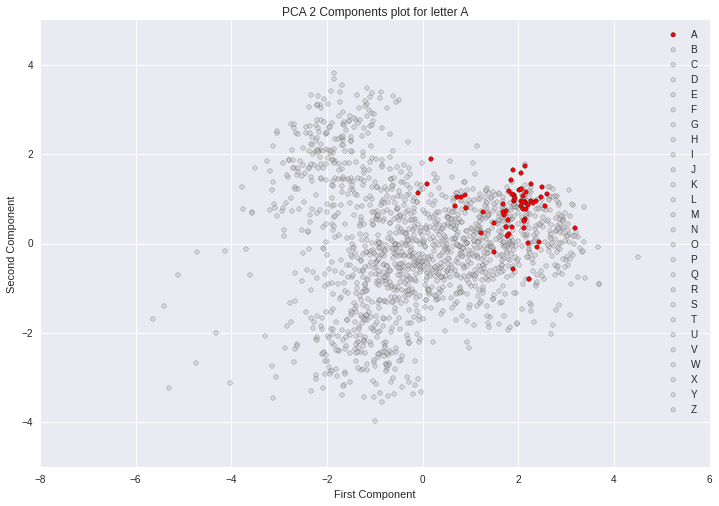

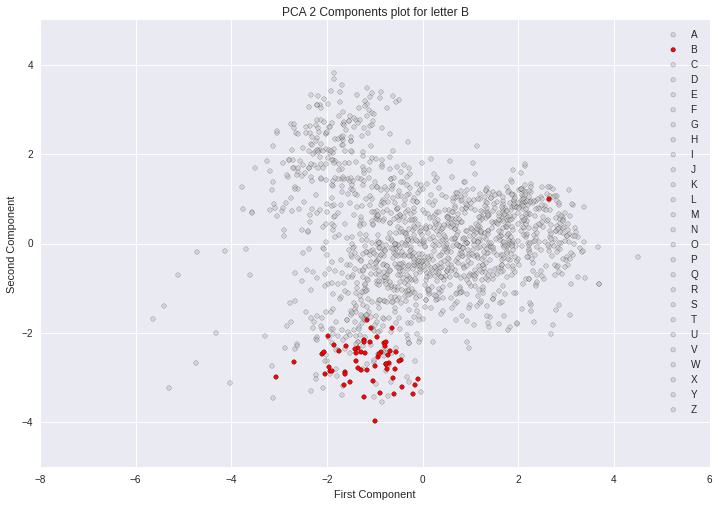

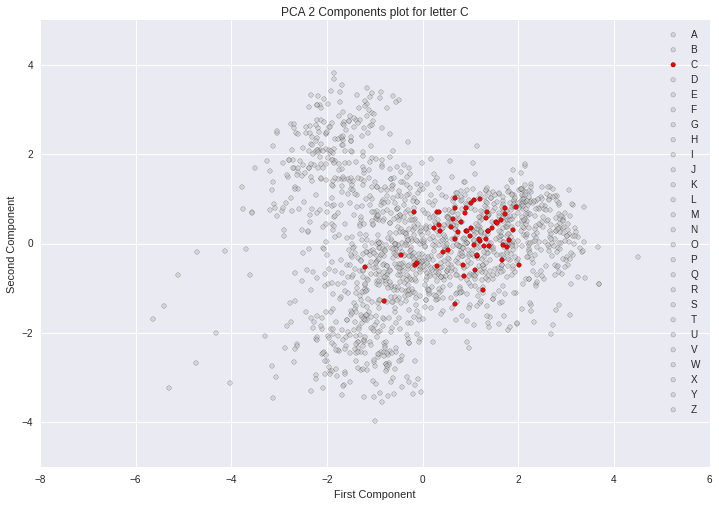

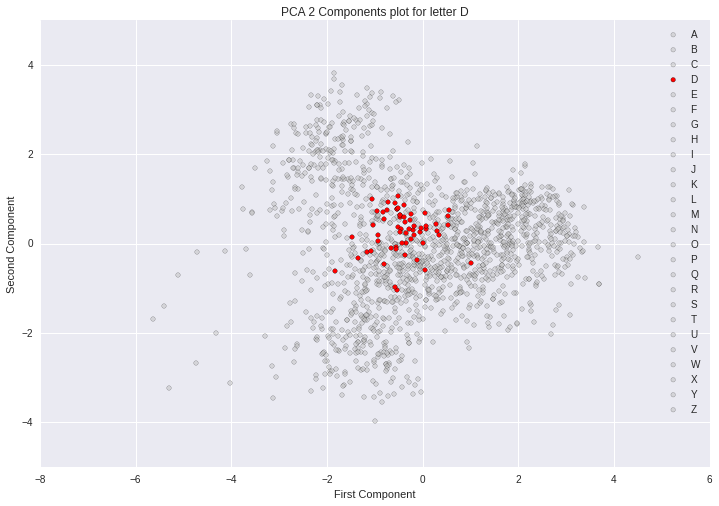

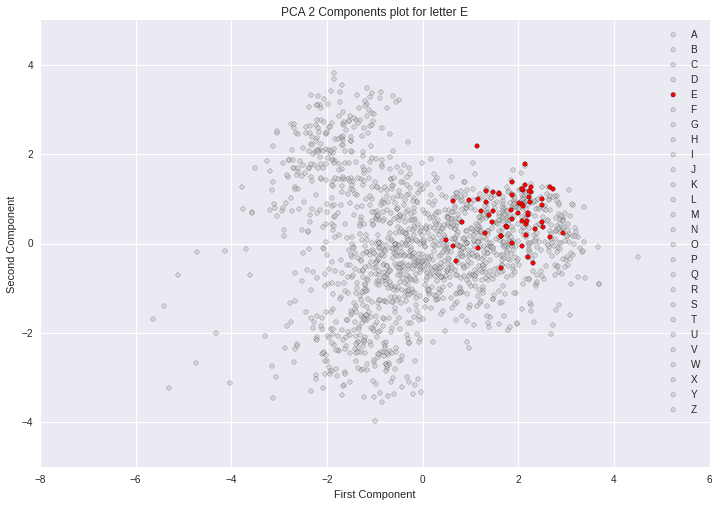

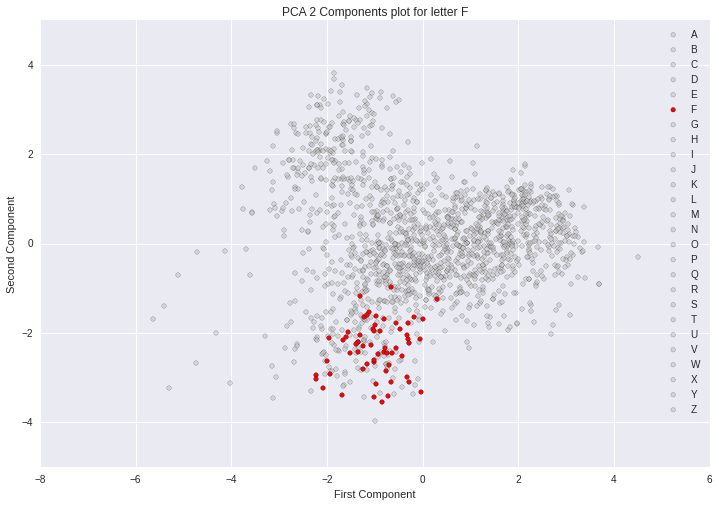

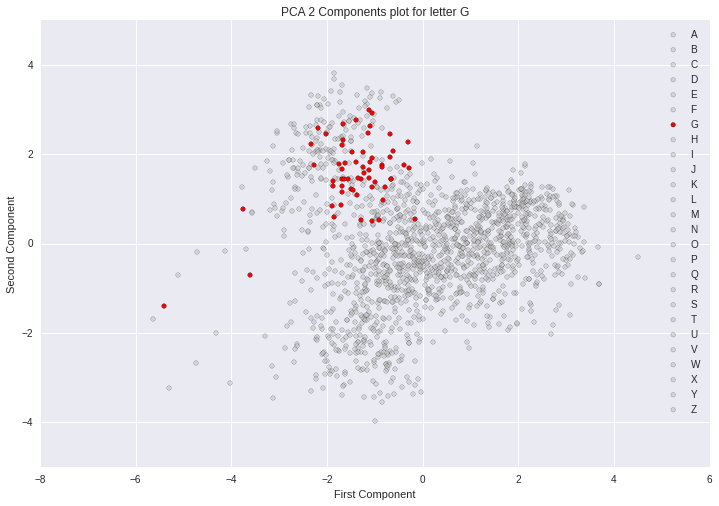

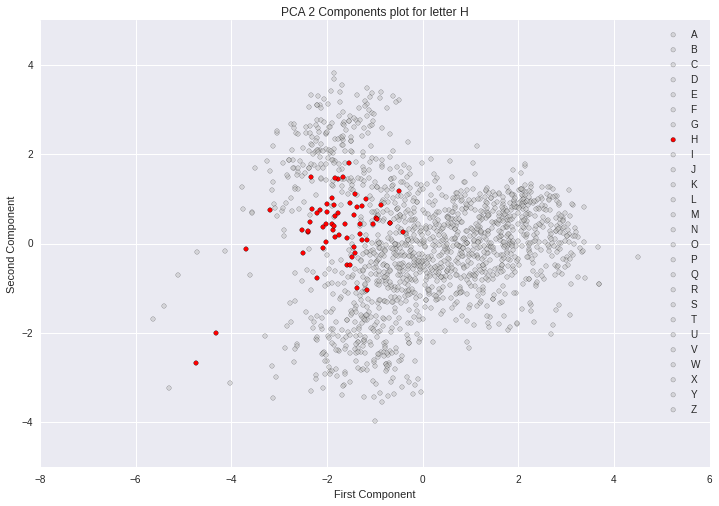

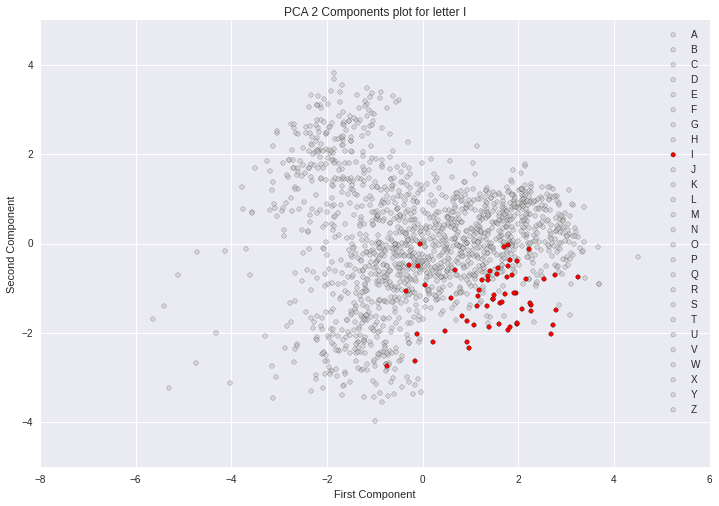

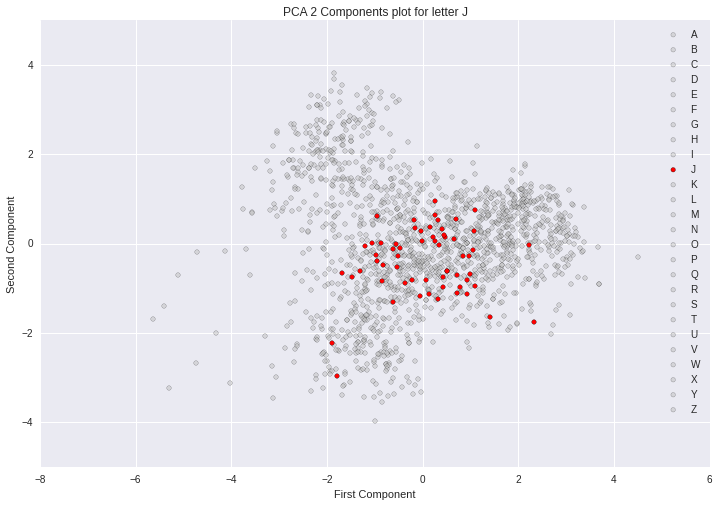

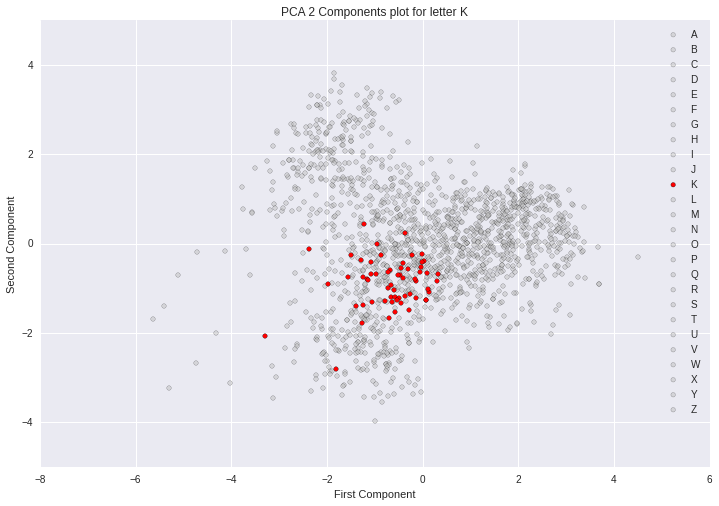

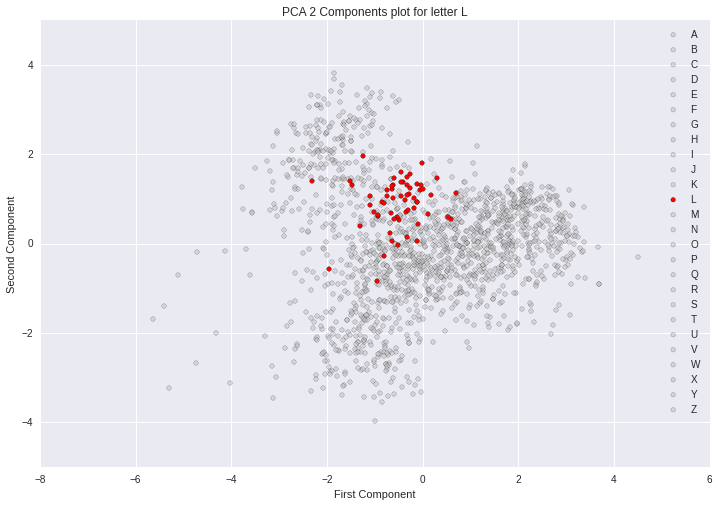

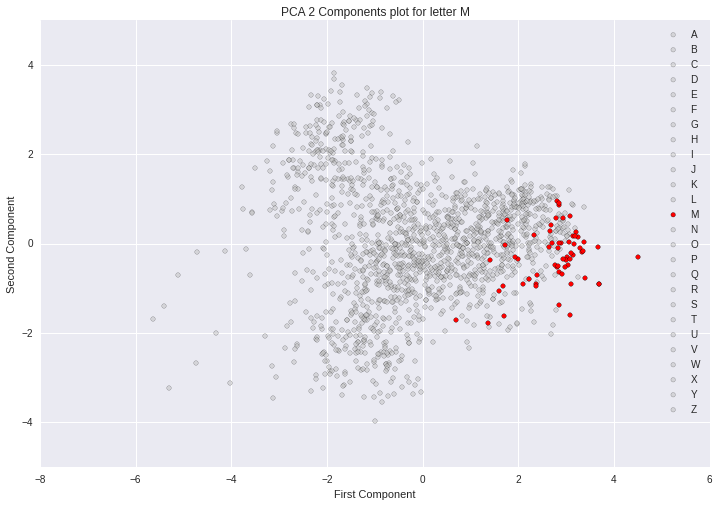

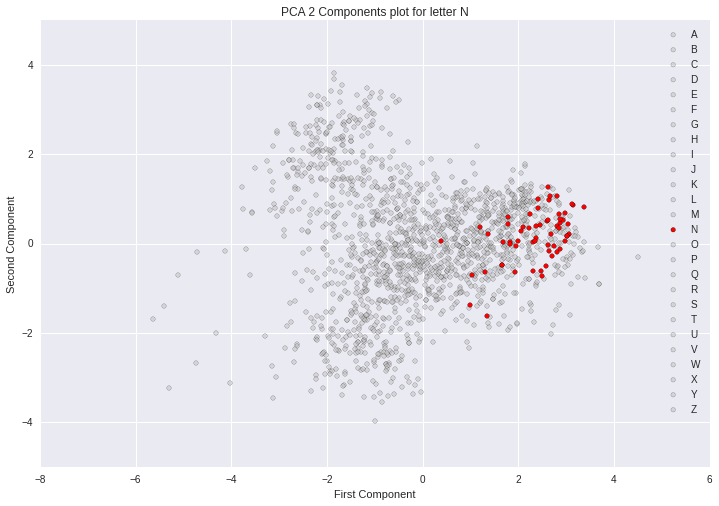

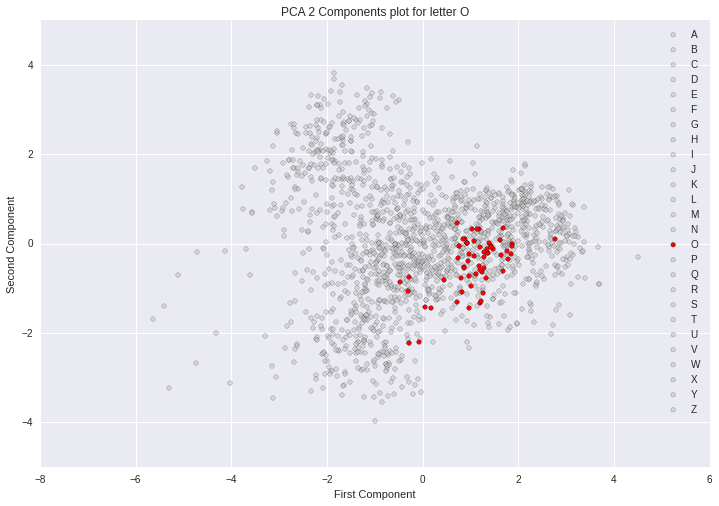

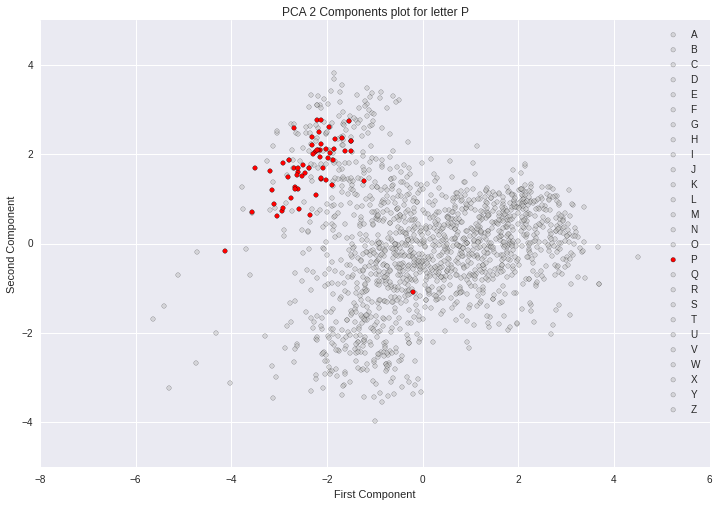

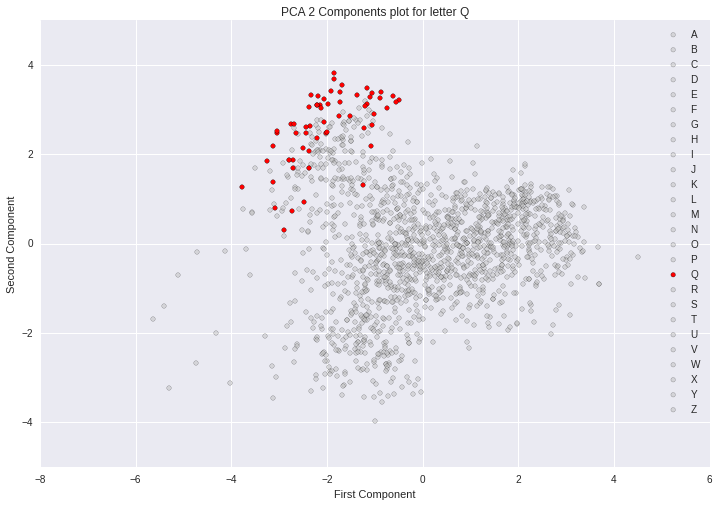

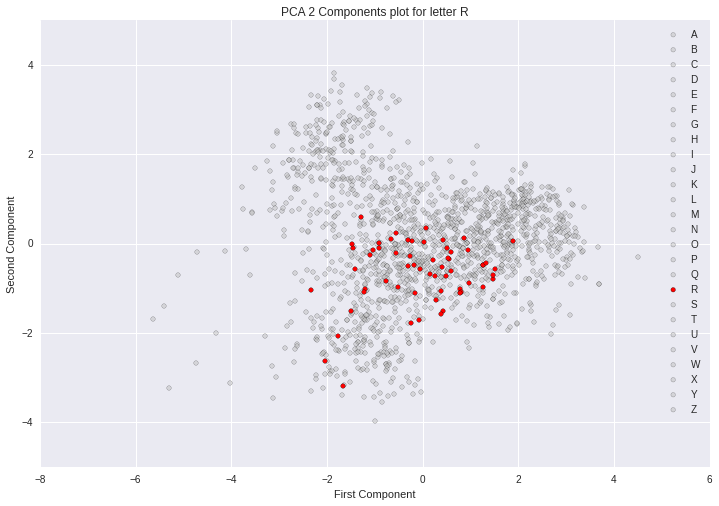

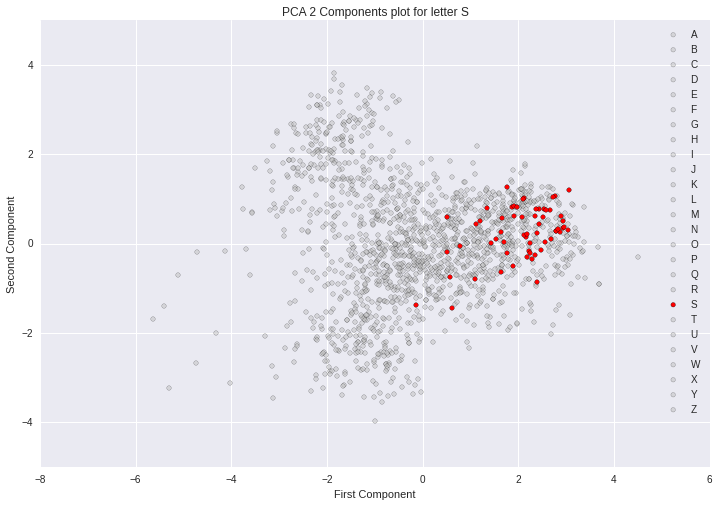

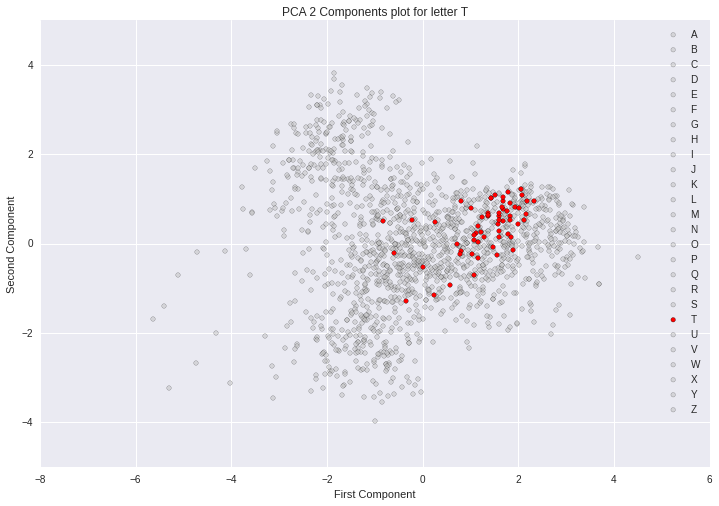

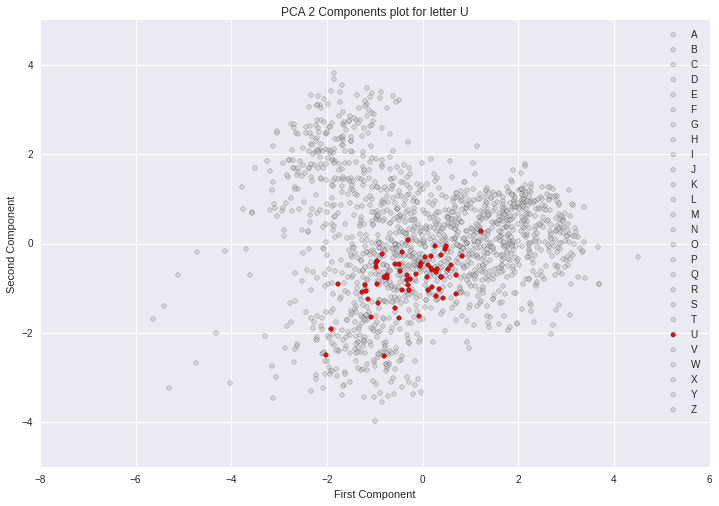

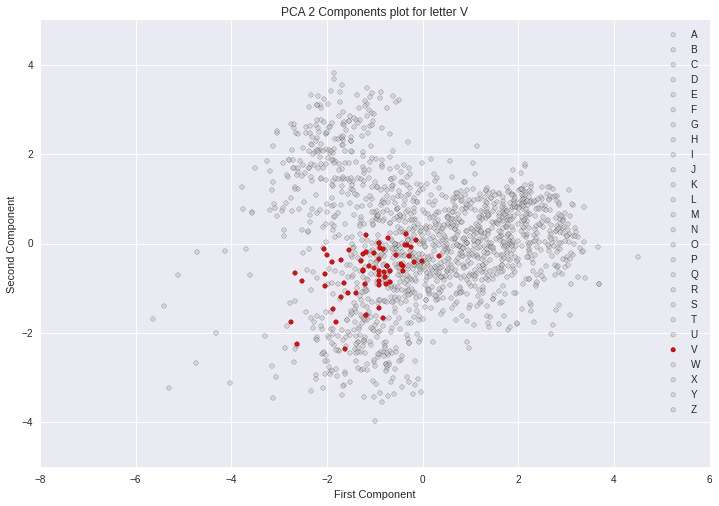

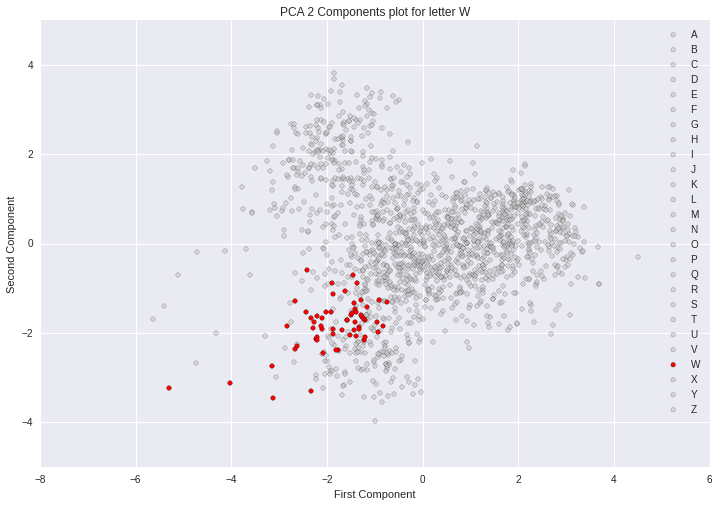

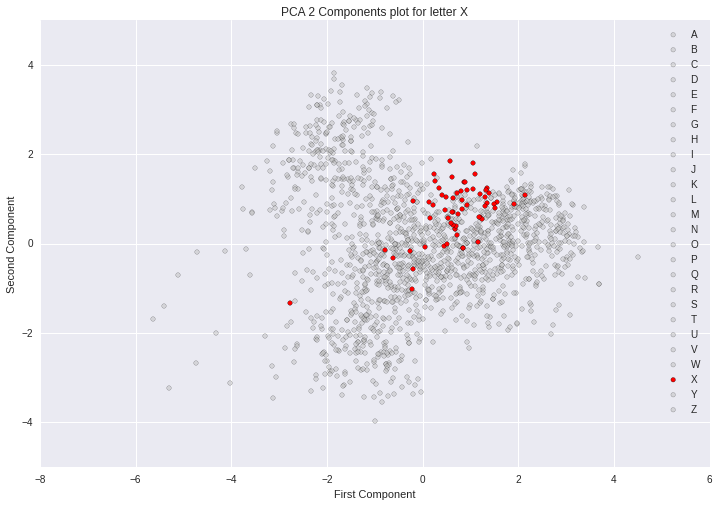

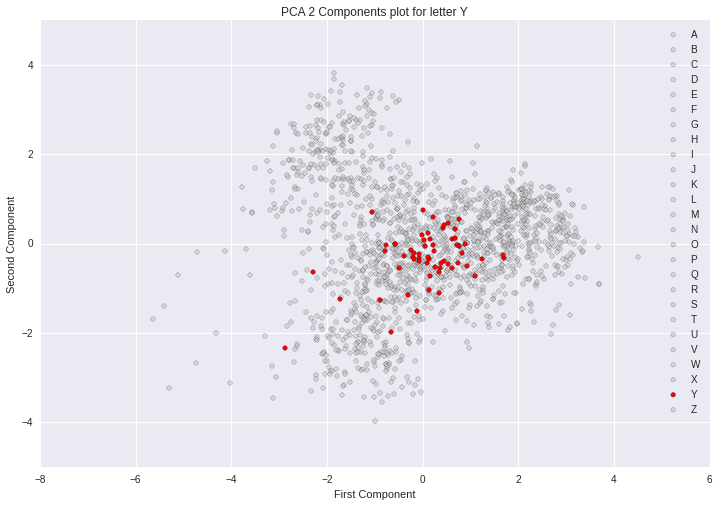

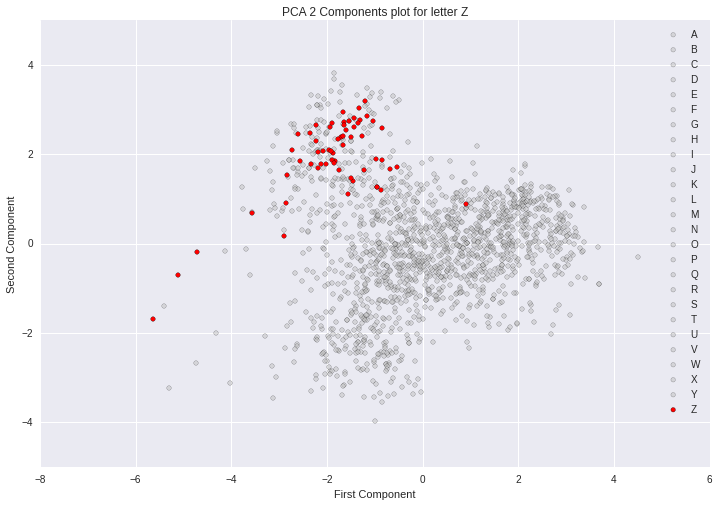

In [11]:
if not os.path.exists(dir_data + consolidated_fn):
        data_consolidate(feature_names) 

df = pd.read_csv(dir_data + consolidated_fn)
cv = 5 # n of folds

fs_cols = ['fThumb', 'fIndex', 'fMiddle', 'fRing', 'fPinky']
c_cols = ['c1', 'c2', 'c3', 'c4']
a_cols = ['aX', 'aY', 'aZ']
g_cols = ['gX', 'gY', 'gZ']



# df.drop(labels=c_cols+a_cols+g_cols, axis=1, inplace=True)
# df.drop(labels=['aZ']+g_cols, axis=1, inplace=True)
# df.drop(labels=['c2','c3','c4'], axis=1, inplace=True)

df.drop(labels=g_cols, axis=1, inplace=True)

run(df, cv)

In [8]:
def get_fit(clf, X_train, y_train): 
    startTime = datetime.now()
    clf.fit(X_train, y_train)
    print("Fitting time: " + str(datetime.now()-startTime))
    return clf
    
def evaluate_cross_validation(clf, K, X_data, y_data):
    # create a k-fold croos validation iterator
    cv = KFold(len(y_data), K, shuffle=True, random_state=0)
    # by default the score used is the one returned by score method of the estimator (accuracy)
    scores = cross_val_score(clf, X_data, y_data, cv=cv)
    print(scores)
    print(("Mean score: {0:.3f} (+/-{1:.3f})").format(np.mean(scores), sem(scores)))

def train_and_evaluate(clf, X_train, y_train, X_test, y_test):
    print("Accuracy on training set:")
    print(clf.score(X_train, y_train))
    print("Accuracy on testing set:")
    print(clf.score(X_test, y_test))
    y_pred = clf.predict(X_test)
    print("Classification Report for test:")
    print(metrics.classification_report(y_test, y_pred))
    print("Confusion Matrix for test:")
    print(metrics.confusion_matrix(y_test, y_pred))
    return clf

def startReport():
    saveout = sys.stdout
    sys.stdout = open(dir_results+secondary_dir_base.split("/")[0]+".txt","a")
    return saveout

def endReport(saveout):
    sys.stdout.close()
    sys.stdout = saveout

def rf_features(rf, X_train, y_train):
    # SVC_best = svm.best_params_
    RF_best = rf.best_params_

    # svm = SVC(kernel=SVC_best['kernel'], C=SVC_best['C'], gamma=SVC_best['gamma'])
    rf = RandomForestClassifier(max_depth=RF_best['max_depth'], n_estimators=RF_best['n_estimators'])
    rf.fit(X_train, y_train)
    
    feature_names = ['fThumb', 'fIndex', 'fMiddle', 'fRing', 'fPinky', 'c1', 'c2', 'c3', 'c4', 'aX', 'aY', 'aZ', 'gX', 'gY', 'gZ', 'label']
    print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), feature_names), reverse=True))
    
    rfe = RFE(estimator=rf, n_features_to_select=12)
    rfe.fit(X_train, y_train)
    ranking = rfe.ranking_
    
    print("\n**RESULTING SUGGESTED FEATURES TO REMOVE (3)**")
    for i in range(len(feature_names)-1):
        if ranking[i] != 1:
            print(feature_names[i])
    


In [16]:
import pandas as pd

from datetime import datetime
from sklearn.externals import joblib

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.feature_selection import RFE

import sys

dir_results = dir_base + "results/"
dir_base = "prediction/"
secondary_dir_base = "wo_g/"
dir_scaler = dir_base + "scaler/"
dir_classifiers = dir_base + "classifiers/"

svm = joblib.load(dir_classifiers+secondary_dir_base+"SVC.pkl")
rf = joblib.load(dir_classifiers+secondary_dir_base+"RandomForestClassifier.pkl")

scaler = joblib.load(dir_scaler+secondary_dir_base+"scaler.pkl")

X_train = pd.read_csv(dir_data+secondary_dir_base+"xtrain.csv")
y_train = pd.read_csv(dir_data+secondary_dir_base+"ytrain.csv")

X_test = pd.read_csv(dir_data+secondary_dir_base+"xtest.csv")
y_test = pd.read_csv(dir_data+secondary_dir_base+"ytest.csv")


save = startReport()
print("\n*******On SVC training and testing evaluation********\n")
train_and_evaluate(svm, X_train, y_train, X_test, y_test)
print("\n*******On RF training and testing evaluation********\n")
train_and_evaluate(rf, X_train, y_train, X_test, y_test)

print("\nEvaluation of random forest's influential features: \n")
if secondary_dir_base is "all/":
    rf_features(rf, X_train, y_train)

print("\nVariances: \n")
get_variance(df, target_names)
endReport(save)